In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


In [3]:
data = pd.read_csv("creditcard_2023.csv", low_memory = False )

# Overview of Datasets

In [4]:
data.head(5).style.background_gradient('Blues')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

* This shows that there are 568630 instances and 31 attributes including the class attribute.
* As you can see there are no null values in any of the column

In [6]:
data.describe().style.background_gradient('Blues')

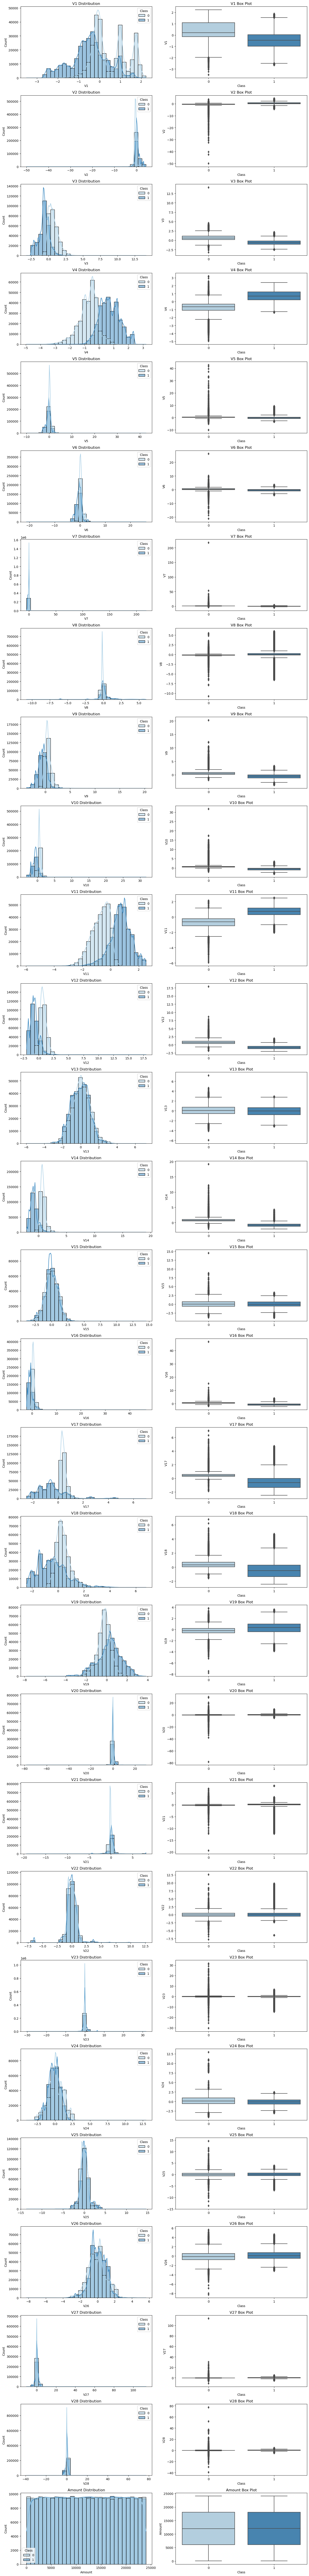

In [7]:
features = data.select_dtypes(include=[np.number]).columns.tolist()
features.remove('id')
features.remove('Class')

fig, ax = plt.subplots(len(features), 2, figsize=(14, len(features)*4))

for idx, column in enumerate(features):
    sns.histplot(x=column, hue="Class", data=data, bins=30, kde=True, palette='Blues', ax=ax[idx,0])
    ax[idx,0].set_title(f"{column} Distribution")
    
    sns.boxplot(x='Class', y=column, data=data, palette='Blues', ax=ax[idx,1])
    ax[idx,1].set_title(f"{column} Box Plot")
    
plt.tight_layout() 
plt.show()

In [8]:
df_no_outliers = data.copy()

for column in features:
    # Compute IQR for the column
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits for 'normal' values
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Remove outliers based on IQR range
    df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_limit) & (df_no_outliers[column] <= upper_limit)]


In [9]:
df_no_outliers.describe().style.background_gradient('Blues')

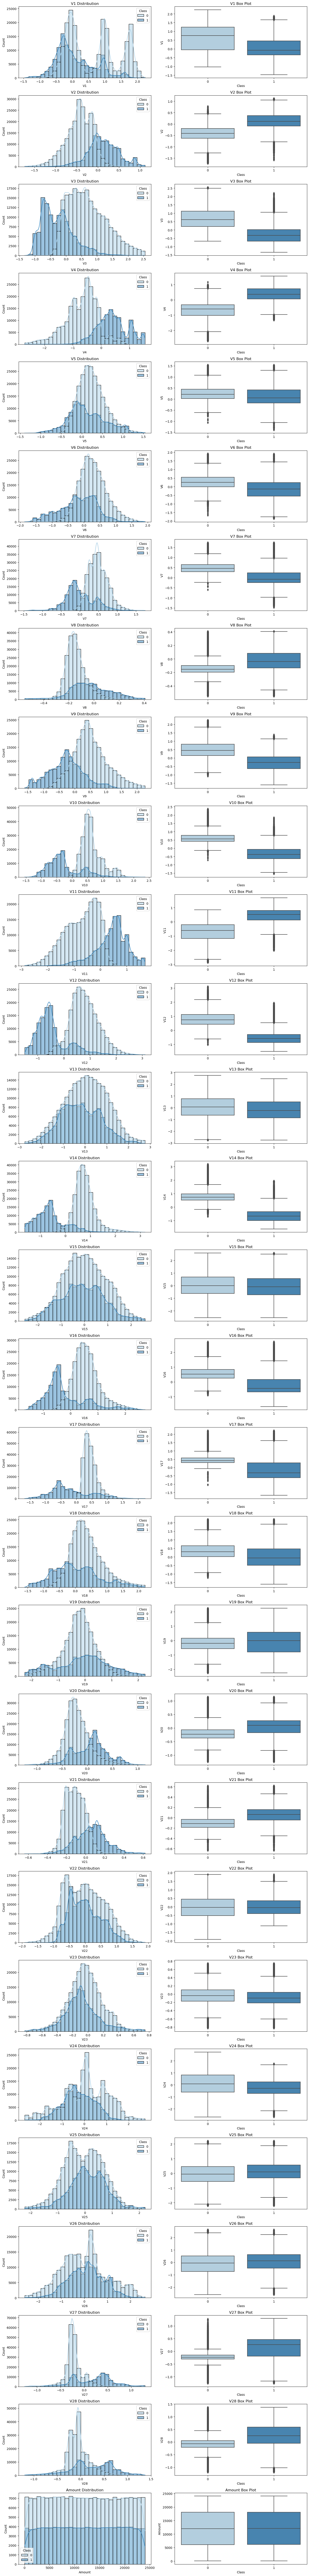

In [10]:
features_1 = df_no_outliers.select_dtypes(include=[np.number]).columns.tolist()
features_1.remove('id')
features_1.remove('Class')

fig, ax = plt.subplots(len(features_1), 2, figsize=(14, len(features_1)*4))

for idx, column in enumerate(features_1):
    sns.histplot(x=column, hue="Class", data=df_no_outliers, bins=30, kde=True, palette='Blues', ax=ax[idx,0])
    ax[idx,0].set_title(f"{column} Distribution")
    
    sns.boxplot(x='Class', y=column, data=df_no_outliers, palette='Blues', ax=ax[idx,1])
    ax[idx,1].set_title(f"{column} Box Plot")
    
plt.tight_layout() 
plt.show()

In [11]:
df_no_outliers['Class'].nunique()

2

In [12]:

data['Class'].nunique()

2

* As expected there are only 2 classes.

In [13]:
(df_no_outliers.Class.value_counts())/(df_no_outliers.Class.count())

0    0.646382
1    0.353618
Name: Class, dtype: float64

In [14]:
#checking the percentage of each class in the dataset
(data.Class.value_counts())/(data.Class.count())

0    0.5
1    0.5
Name: Class, dtype: float64

# Lets Explore the CLass 

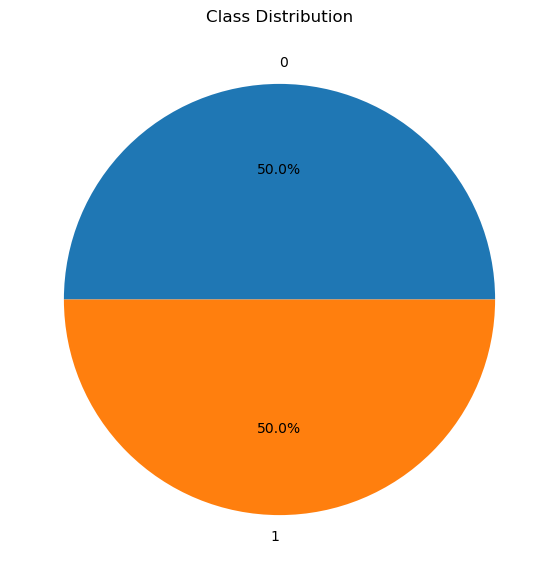

In [15]:
counts = data['Class'].value_counts()

plt.figure(figsize=(8,7))
plt.pie(counts, labels = counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

* This shows a complete balance of classes. There are 50% 'Genuine' (0) instances and only 50% 'Fraudulent' (1) instances. 

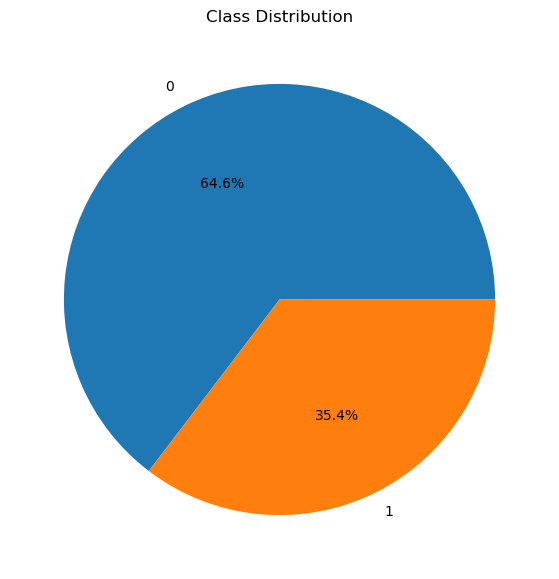

In [16]:
counts = df_no_outliers['Class'].value_counts()

plt.figure(figsize=(8,7))
plt.pie(counts, labels = counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

In [17]:
#checking distribution of  Target columns (equally distributed)
data['Class'].value_counts()  

0    284315
1    284315
Name: Class, dtype: int64

In [18]:
df_no_outliers['Class'].value_counts()  

0    211180
1    115531
Name: Class, dtype: int64

In [19]:
print("*********Losses due to fraud:************\n")
print("Total amount lost to fraud")
print(df_no_outliers.Amount[df_no_outliers.Class == 1].sum())
print("Mean amount per fraudulent transaction")
print(df_no_outliers.Amount[df_no_outliers.Class == 1].mean())
print("Compare to normal transactions:")
print("Total amount from normal transactions")
print(df_no_outliers.Amount[df_no_outliers.Class == 0].sum())
print("Mean amount per normal transactions")
print(df_no_outliers.Amount[df_no_outliers.Class == 0].mean())

*********Losses due to fraud:************

Total amount lost to fraud
1394559635.1100001
Mean amount per fraudulent transaction
12070.869594394579
Compare to normal transactions:
Total amount from normal transactions
2538257099.5100007
Mean amount per normal transactions
12019.400982621464


# Let's take a look at the V1,...,V28 features.

In [20]:
vfeatures = df_no_outliers.iloc[:,1:30].columns
print(vfeatures)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


# Checking correlation between features and the likelihood of the transaction to be fraud on the unbalanced dataset

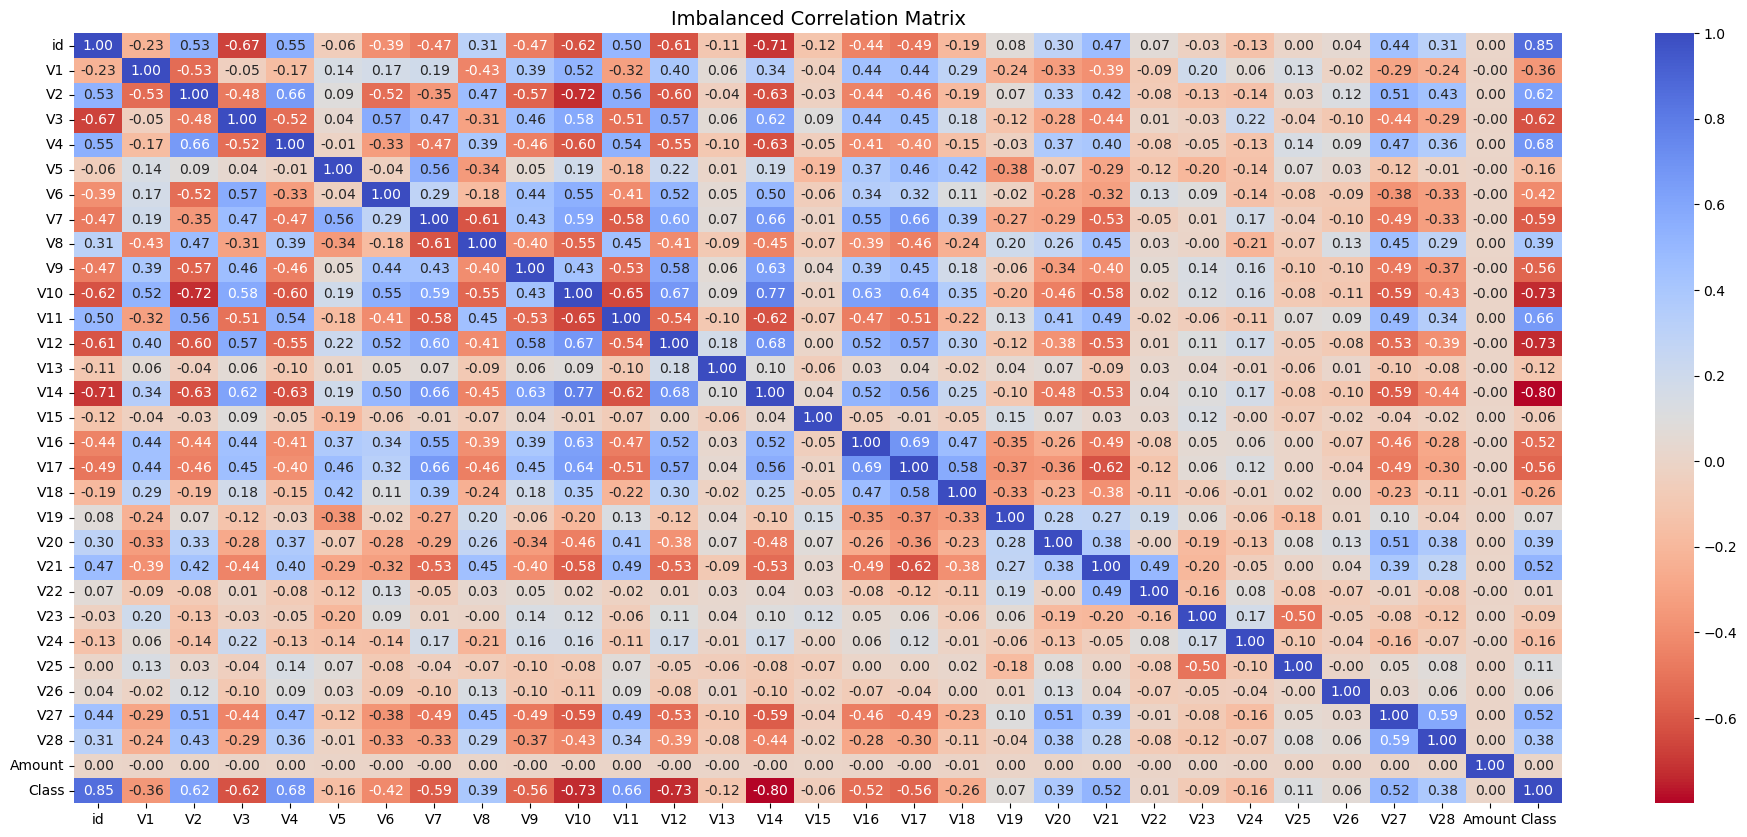

In [21]:
f, ax1 = plt.subplots(figsize=(24, 10))

# Assuming df_no_outliers is your DataFrame after removing outliers
corr = df_no_outliers.corr()

# 'annot=True' to add text to each block, 'fmt' to format the text displayed
sns.heatmap(corr, cmap='coolwarm_r', annot=True, fmt=".2f", annot_kws={'size':10}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

### Separating response variable and predictors

In [22]:
X_data1 = df_no_outliers.iloc[:,1:30]
y_data1 = df_no_outliers.iloc[:, -1]

In [23]:
X_data1

V1        V2        V3        V4        V5        V6        V7  \
0      -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1       0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
3      -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4      -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   
5       0.025302 -0.140514  1.191138 -0.707979  0.430490  0.458973  0.611050   
...          ...       ...       ...       ...       ...       ...       ...   
568619 -0.443917  0.243549  0.126811  0.400266 -0.326371  0.517670  0.086289   
568621 -0.739211  0.231882 -0.410204  0.511278  0.056859 -0.410720 -0.383799   
568624 -0.542349  0.585098 -0.547730  1.005465 -0.702046 -0.287417 -0.835174   
568627 -0.311997 -0.004095  0.137526 -0.035893 -0.042291  0.121098 -0.070958   
568628  0.636871 -0.516970 -0.300889 -0.144480  0.131042 -0.294148  0.580568   

              V8        V9       V10  ...       V20       V21       V22  \
0      -0.130006  0.727159  0.637735  ...  0.091202 -0.110552  0.217606   
1      -0.133118  0.347452  0.529808  ... -0.233984 -0.194936 -0.605761   
3      -0.065130 -0.205698  0.575231  ... -0.378223 -0.146927 -0.038212   
4      -0.212660  1.049921  0.968046  ...  0.247237 -0.106984  0.729727   
5      -0.092629  0.180811  0.451788  ... -0.076400 -0.187739 -0.538518   
...          ...       ...       ...  ...       ...       ...       ...   
568619 -0.455818  0.562490 -0.005988  ... -0.151659  0.413249  0.108057   
568621 -0.313642  0.098006 -0.523529  ... -0.241586  0.283048 -0.603132   
568624  0.382365 -1.281525 -0.950131  ...  0.786416  0.463312  0.705032   
568627 -0.019997 -0.122048 -0.144495  ... -0.076417  0.140788  0.536523   
568628 -0.207723  0.893527 -0.080078  ...  0.288186 -0.060381 -0.195609   

             V23       V24       V25       V26       V27       V28    Amount  
0      -0.134794  0.165959  0.126280 -0.434824 -0.081230 -0.151045  17982.10  
1       0.079469 -0.577395  0.190090  0.296503 -0.248052 -0.064512   6531.37  
3      -0.214048 -1.893131  1.003963 -0.515950 -0.165316  0.048424   5384.44  
4      -0.161666  0.312561 -0.414116  1.071126  0.023712  0.419117  14278.97  
5      -0.050465 -0.631553 -0.456480  0.252670  0.066681  0.095812   6901.49  
...          ...       ...       ...       ...       ...       ...       ...  
568619  0.053214  1.062932 -0.562127 -0.716076 -0.854772 -0.470452  10821.44  
568621 -0.479224 -0.453026 -0.005507 -1.644165 -0.913953  1.292782  18363.07  
568624 -0.124074  0.046466 -0.196141  0.553614  1.222537  1.172982  10145.64  
568627 -0.211100 -0.448909  0.540073 -0.755836 -0.487540 -0.268741  23572.85  
568628 -0.175488 -0.554643 -0.099669 -1.434931 -0.159269 -0.076251  10160.83  

[326711 rows x 29 columns]

In [24]:
y_data1

0         0
1         0
3         0
4         0
5         0
         ..
568619    1
568621    1
568624    1
568627    1
568628    1
Name: Class, Length: 326711, dtype: int64

In [43]:
y_data1.value_counts()

0    211180
1    115531
Name: Class, dtype: int64

In [25]:
print(X_data1.shape, y_data1.shape)

(326711, 29) (326711,)


# Lets standardize the data

In [26]:
sc = StandardScaler()

In [27]:
x_scaled1 = sc.fit_transform(X_data1)
x_scaled_df1 = pd.DataFrame(x_scaled1,columns=X_data1.columns)

In [45]:
x_scaled = sc.fit_transform(X_data)
x_scaled_df = pd.DataFrame(x_scaled,columns=X_data.columns)

In [28]:
x_scaled_df1.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -0.936055 -0.537124  2.859469  0.285558 -0.197675  1.154458  0.517989   
1  0.692383 -0.274909  0.269588 -0.162375  0.189867  0.584462  0.232108   
2 -0.794229 -0.627858  1.858068 -1.017667  0.117188  1.923236  0.516097   
3 -0.865690  0.165408  1.564383 -0.186510 -0.259583  0.775422  0.873184   
4 -0.562261  0.222573  1.115526 -0.522769  0.592892  0.641348  0.751769   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0 -0.215599  0.740018  0.551286  ...  0.603467 -0.396396  0.394392 -0.367649   
1 -0.238677  0.169882  0.371485  ... -0.375643 -0.939898 -1.034401  0.557944   
2  0.265473 -0.660681  0.447157  ... -0.809936 -0.630683 -0.049531 -0.710016   
3 -0.828498  1.224649  1.101569  ...  1.073276 -0.373418  1.283079 -0.483730   
4  0.061564 -0.080332  0.241508  ...  0.098830 -0.893547 -0.917714 -0.003356   

        V24       V25       V26       V27       V28    Amount  
0  0.246242  0.180727 -0.482376 -0.008609 -0.493598  0.858875  
1 -0.557866  0.271150  0.313471 -0.466992 -0.267105 -0.795553  
2 -1.981136  1.424472 -0.570660 -0.239656  0.028493 -0.961264  
3  0.404825 -0.585057  1.156434  0.279744  0.998750  0.323838  
4 -0.616450 -0.645089  0.265771  0.397813  0.152527 -0.742077  

[5 rows x 29 columns]

# Spliting the data into Train_test_split

In [29]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(x_scaled_df1, y_data1, test_size=0.2, random_state=42, stratify=y_data1)

In [30]:
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(261368, 29)
(65343, 29)
(261368,)
(65343,)


# Model Buiding

In [32]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier(eval_metric='logloss')
}

param_grids = {
    'DecisionTreeClassifier': {
        'max_depth': [3, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'leaf_size': [20, 30, 40],
        'p': [1, 2]
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 6, 8],
        'criterion': ['gini', 'entropy']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

best_params = {}

for model_name, model in models.items():
    print(f"Running GridSearchCV for {model_name}")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train1, y_train1)
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {best_params[model_name]}")



Running GridSearchCV for DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Running GridSearchCV for RandomForestClassifier
Best parameters for RandomForestClassifier: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Running GridSearchCV for GradientBoostingClassifier
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Running GridSearchCV for KNeighborsClassifier


c:\Users\12019\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Best parameters for KNeighborsClassifier: {'leaf_size': 20, 'n_neighbors': 3, 'p': 1}
Running GridSearchCV for XGBClassifier
Best parameters for XGBClassifier: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [34]:
DTC_model = DecisionTreeClassifier(max_depth = 20, min_samples_leaf =1, min_samples_split = 2)
DTC_model.fit(X_train1, y_train1)

y_pred_DTC = DTC_model.predict(X_test1)

print("Confusion Matrix:\n", confusion_matrix(y_test1, y_pred_DTC))
print("\nClassification Report:\n", classification_report(y_test1, y_pred_DTC))
print("\nAccuracy Score:", accuracy_score(y_test1, y_pred_DTC))

Confusion Matrix:
 [[42132   105]
 [   42 23064]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42237
           1       1.00      1.00      1.00     23106

    accuracy                           1.00     65343
   macro avg       1.00      1.00      1.00     65343
weighted avg       1.00      1.00      1.00     65343


Accuracy Score: 0.9977503328589137


In [35]:
RFC_model = RandomForestClassifier(n_estimators=100, random_state=42)
RFC_model.fit(X_train1, y_train1)

y_pred_RFC = RFC_model.predict(X_test1)

print("Confusion Matrix:\n", confusion_matrix(y_test1, y_pred_RFC))
print("\nClassification Report:\n", classification_report(y_test1, y_pred_RFC))
print("\nAccuracy Score:", accuracy_score(y_test1, y_pred_RFC))

Confusion Matrix:
 [[42230     7]
 [    0 23106]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42237
           1       1.00      1.00      1.00     23106

    accuracy                           1.00     65343
   macro avg       1.00      1.00      1.00     65343
weighted avg       1.00      1.00      1.00     65343


Accuracy Score: 0.9998928729932816


In [36]:
XGB_model = XGBClassifier(colsample_bytree= 0.8, learning_rate= 0.2, max_depth= 7, n_estimators= 300, subsample=0.8)
XGB_model.fit(X_train1, y_train1)

# Make predictions on the test set
y_pred_XGB = XGB_model.predict(X_test1)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test1, y_pred_XGB))
print("\nClassification Report:\n", classification_report(y_test1, y_pred_XGB))
print("\nAccuracy Score:", accuracy_score(y_test1, y_pred_XGB))

Confusion Matrix:
 [[42227    10]
 [    0 23106]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42237
           1       1.00      1.00      1.00     23106

    accuracy                           1.00     65343
   macro avg       1.00      1.00      1.00     65343
weighted avg       1.00      1.00      1.00     65343


Accuracy Score: 0.9998469614189738


In [37]:
GBC_model = GradientBoostingClassifier(learning_rate= 0.2, max_depth =7, n_estimators= 300)
GBC_model.fit(X_train1, y_train1)

# Make predictions on the test set
y_pred_GBC = GBC_model.predict(X_test1)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test1, y_pred_GBC))
print("\nClassification Report:\n", classification_report(y_test1, y_pred_GBC))
print("\nAccuracy Score:", accuracy_score(y_test1, y_pred_GBC))

Confusion Matrix:
 [[42228     9]
 [    0 23106]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     42237
           1       1.00      1.00      1.00     23106

    accuracy                           1.00     65343
   macro avg       1.00      1.00      1.00     65343
weighted avg       1.00      1.00      1.00     65343


Accuracy Score: 0.9998622652770763


# Ploting a Heatmap Graph for each model

<Axes: >

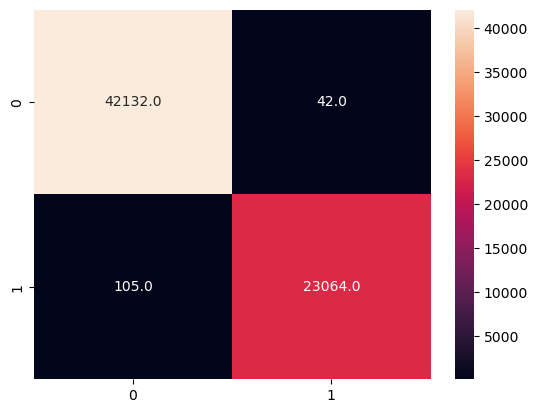

In [53]:
sns.heatmap(confusion_matrix(y_pred_DTC,y_test1),annot=True,fmt=".1f")

<Axes: >

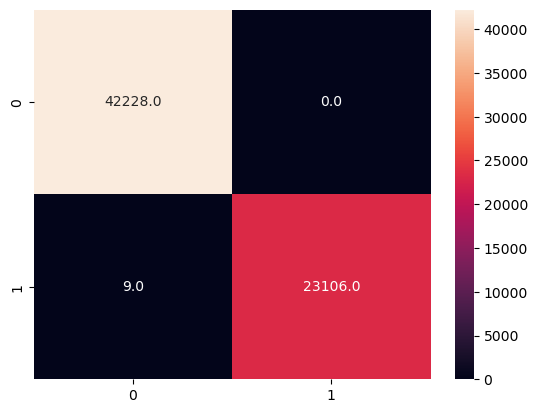

In [54]:
sns.heatmap(confusion_matrix(y_pred_GBC,y_test1),annot=True,fmt=".1f")

<Axes: >

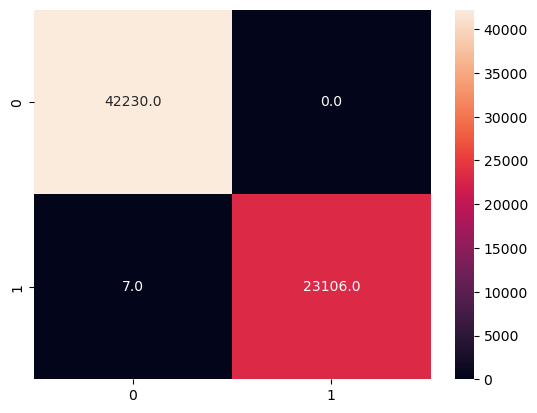

In [55]:
sns.heatmap(confusion_matrix(y_pred_RFC,y_test1),annot=True,fmt=".1f")

<Axes: >

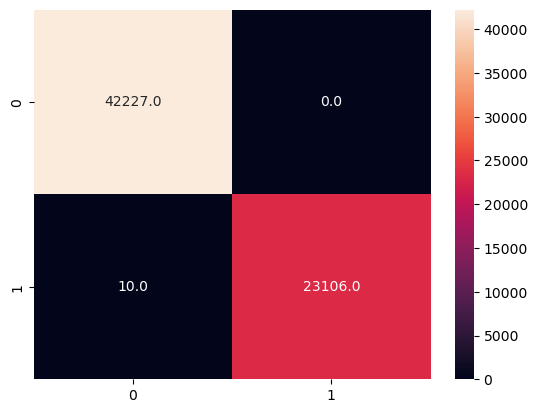

In [56]:
sns.heatmap(confusion_matrix(y_pred_XGB,y_test1),annot=True,fmt=".1f")

# Plotting a Confusion Matrix with Heatmap for each model

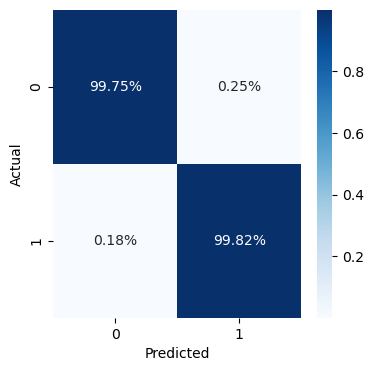

In [57]:
cm = confusion_matrix(y_test1, y_pred_DTC)
# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cmn, annot=True, fmt='.2%', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

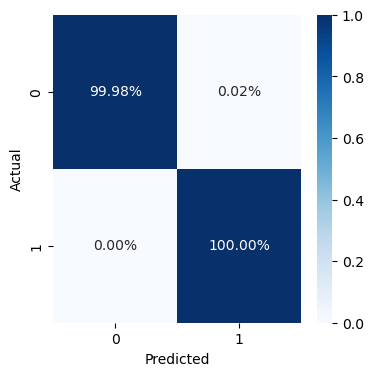

In [58]:
cm = confusion_matrix(y_test1, y_pred_GBC)
# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cmn, annot=True, fmt='.2%', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

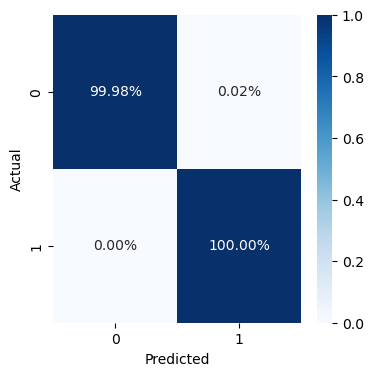

In [59]:
cm = confusion_matrix(y_test1, y_pred_RFC)
# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cmn, annot=True, fmt='.2%', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

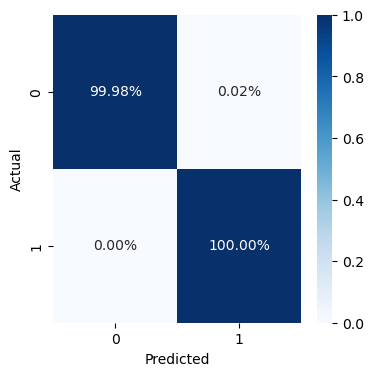

In [60]:
cm = confusion_matrix(y_test1, y_pred_XGB)
# Normalize confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cmn, annot=True, fmt='.2%', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
# 